In [12]:
import numpy as np
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.utils import to_categorical


from tqdm import tqdm

In [2]:
# Przykład przetwarzania danych - wyodrębnienie obrazów
# def extract_word_images(data):
#     word_images = []
#     for index, row in data.iterrows():
#         # Wczytaj obraz główny (zakładając, że masz obraz zawierający słowa)
#         main_image = cv2.imread('main_image.png', cv2.IMREAD_GRAYSCALE)
# 
#         # Wyciągnij fragment obrazu na podstawie współrzędnych ramki otaczającej
#         x, y, w, h = row['bbox_x'], row['bbox_y'], row['bbox_w'], row['bbox_h']
#         word_image = main_image[y:y + h, x:x + w]
# 
#         # Przykładowe skalowanie obrazu do ustalonego rozmiaru (np. 28x28)
#         word_image = cv2.resize(word_image, (28, 28))
# 
#         # Dodaj obraz do listy obrazów słów
#         word_images.append(word_image)
# 
#     return word_images

### Display example

Image Path: Datasets\iam_words\words\a01\a01-113u\a01-113u-05-00.png
Label: nor


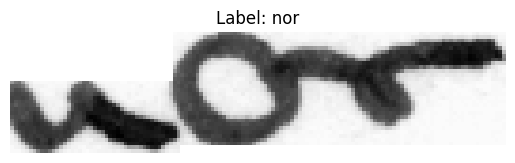

Image Path: Datasets\iam_words\words\a03\a03-040\a03-040-01-03.png
Label: showed


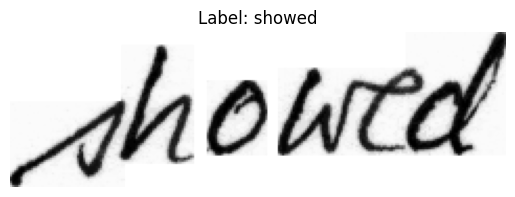

Image Path: Datasets\iam_words\words\a02\a02-086\a02-086-01-05.png
Label: he


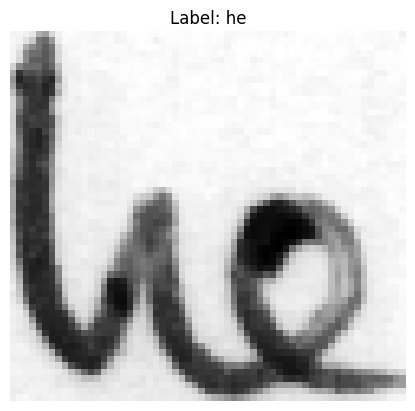

Image Path: Datasets\iam_words\words\a03\a03-043\a03-043-04-03.png
Label: cent


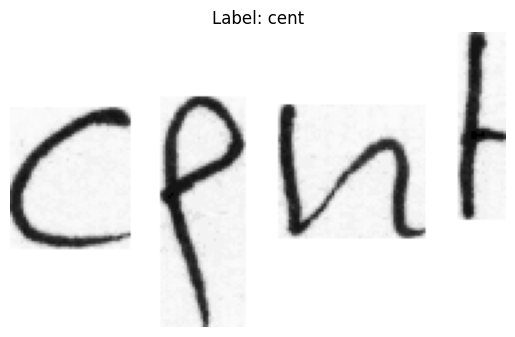

Image Path: Datasets\iam_words\words\a01\a01-063u\a01-063u-03-02.png
Label: Dr.


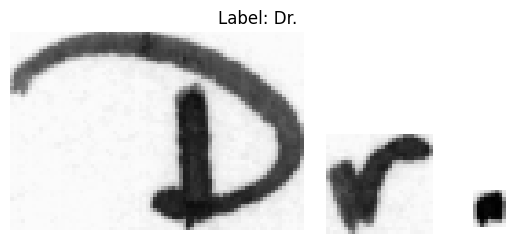

In [13]:
def display_example(image_path, label):
    img = Image.open(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()
    
sample_examples = random.sample(dataset, 5)

for example in sample_examples:
    image_path, label = example
    print(f"Image Path: {image_path}")
    print(f"Label: {label}")
    display_example(image_path, label)

### Main code

In [63]:
sentences_txt_path = os.path.join("Datasets", "words_new.txt")
sentences_folder_path = os.path.join("Datasets", "iam_words", "words")

dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()

for line in tqdm(words[:10000]):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == 'err':
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    rel_path = os.path.join(sentences_folder_path, folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9960.87it/s]


In [16]:
def load_word_images(dataset):
    images = []
    labels = []

    for image_path, label in dataset:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img_to_array(img) / 255.0  # Normalizacja
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [39]:
IMG_HEIGHT, IMG_WIDTH = 64, 128  # Rozmiar obrazu

images, labels = load_word_images(dataset)

# Augmentacja danych
datagen = ImageDataGenerator(
    rotation_range=10,       # Rotacja o max 10 stopni
    width_shift_range=0.1,   # Przesunięcie poziome
    height_shift_range=0.1,  # Przesunięcie pionowe
    shear_range=0.15,        # Zniekształcenie
    zoom_range=0.1,          # Powiększenie
    brightness_range=[0.8, 1.2],  # Zmiana jasności
    fill_mode='nearest'      # Wypełnienie pikseli poza granicą
)

augmented_images = []
augmented_labels = []

for i in range(len(images)):
    img = images[i]
    label = labels[i]
    img = img.reshape((1, IMG_HEIGHT, IMG_WIDTH, 1))  # Dopasowanie wymiarów do generatora

    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        if len(augmented_images) >= 5 * len(images):  # Zatrzymanie augmentacji po wygenerowaniu 5-krotności danych
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

C:\Users\maksy\PycharmProjects\NN\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maksy\PycharmProjects\NN\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 377s 284ms/step - accuracy: 0.8263 - loss: 1.9542 - val_accuracy: 0.8323 - val_loss: 1.4288
Epoch 2/10


C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1306/1306 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8323 - val_loss: 1.4288
Epoch 3/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 195s 149ms/step - accuracy: 0.8354 - loss: 1.5334 - val_accuracy: 0.8323 - val_loss: 1.4307
Epoch 4/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8323 - val_loss: 1.4307
Epoch 5/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 203s 155ms/step - accuracy: 0.8339 - loss: 1.5192 - val_accuracy: 0.8322 - val_loss: 1.4421
Epoch 6/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8322 - val_loss: 1.4421
Epoch 7/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 204s 156ms/step - accuracy: 0.8324 - loss: 1.5111 - val_accuracy: 0.8322 - val_loss: 1.4457
Epoch 8/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8322 - val_loss: 1.4457
Epoch 9/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 196s 150m

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 62, 126, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 31, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 29, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 12, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 6, 14, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 10752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       1,376,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1971)                │         254,259 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,169,947 (19.72 MB)

 Trainable params: 1,723,315 (6.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,446,632 (13.15 MB)

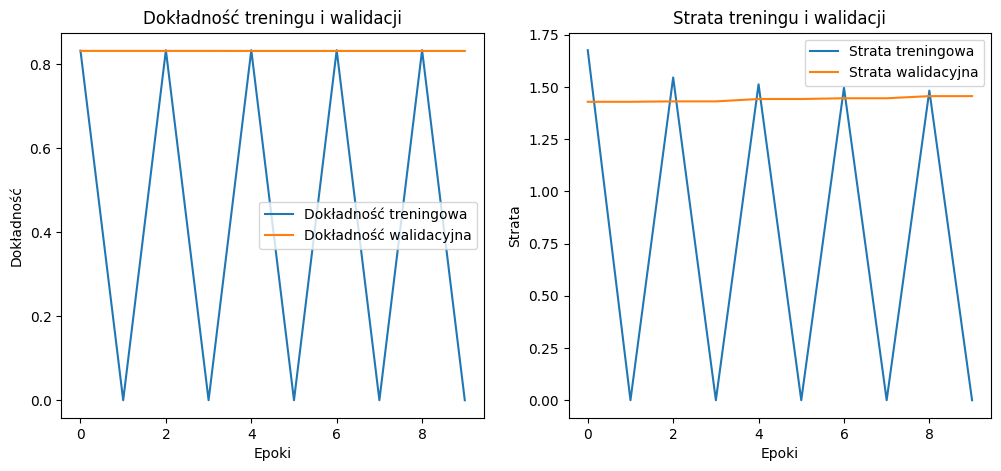

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Stałe
BATCH_SIZE = 32
# IMG_HEIGHT, IMG_WIDTH = 64, 128  # Rozmiar obrazu

# images, labels = load_word_images(dataset)

# augmented_images = images
# augmented_labels = labels

# Kodowanie etykiet
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(augmented_labels)  # użycie zaugmentowanych etykiet
y_categorical = to_categorical(y_encoded)

# Podział danych na treningowe i walidacyjne
X_train, X_val, y_train, y_val = train_test_split(augmented_images, y_categorical, test_size=0.2, random_state=42)

# Definicja modelu
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Augmentacja danych podczas treningu
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Trenowanie modelu
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=10
)

# Podsumowanie modelu
model.summary()

# Wykresy krzywych uczenia i błędu
plt.figure(figsize=(12, 5))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność treningu i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

# Wykres błędu
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata treningu i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     Reshape, Dense, GRU, Lambda, add, concatenate)
from tensorflow.keras import backend as K
import tensorflow as tf

# CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, :, :]  # Adjust if necessary
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Configuration dictionary
word_cfg = {
    'img_w': 128,
    'img_h': 64,
    'max_text_len': 32
}
num_classes = 80  # Adjust to your specific number of classes

def word_model():
    img_w = word_cfg['img_w']
    img_h = word_cfg['img_h']
    max_text_len = word_cfg['max_text_len']

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    input_data = Input(name='the_input', shape=input_shape, dtype='float32')

    # Convolutional layers
    inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='conv1')(input_data)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

    inner = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='conv2')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)

    inner = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='conv3')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='conv4')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)

    inner = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='conv5')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='conv6')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)

    inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='conv7')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # Reshape and RNN layers
    inner = Reshape(target_shape=((32, 2048)), name='reshape')(inner)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

    gru_1 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    reversed_gru_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1))(gru_1b)

    gru1_merged = add([gru_1, reversed_gru_1b])
    gru1_merged = BatchNormalization()(gru1_merged)

    gru_2 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
    reversed_gru_2b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1))(gru_2b)

    gru2_merged = concatenate([gru_2, reversed_gru_2b])
    gru2_merged = BatchNormalization()(gru2_merged)

    inner = Dense(num_classes, kernel_initializer='he_normal', name='dense2')(gru2_merged)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [y_pred, labels, input_length, label_length]
    )

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
    model_predict = Model(inputs=input_data, outputs=y_pred)

    model_predict.summary()

    return model, model_predict


### Fajne pokazanie co jest nie tak w wyodrębnianiu znaków

Image Path: Datasets\iam_words\words\a01\a01-003\a01-003-01-03.png
Label: Labour


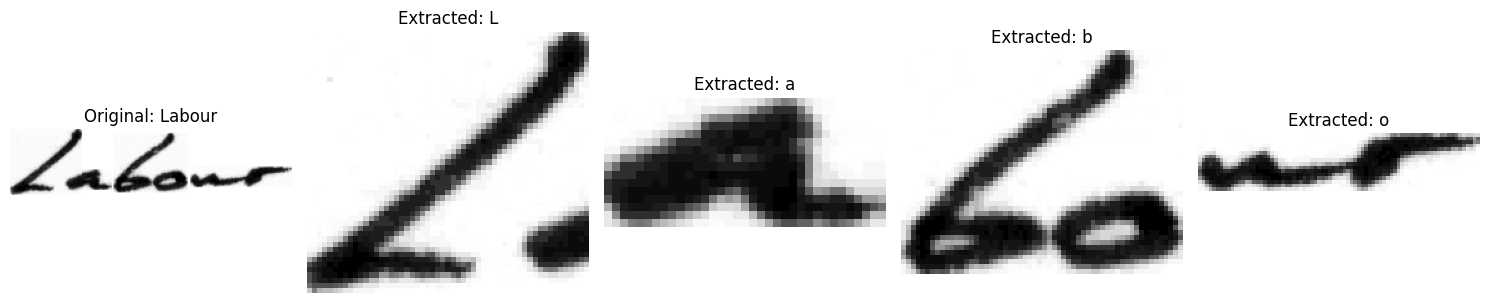

Image Path: Datasets\iam_words\words\a01\a01-007u\a01-007u-04-06.png
Label: number


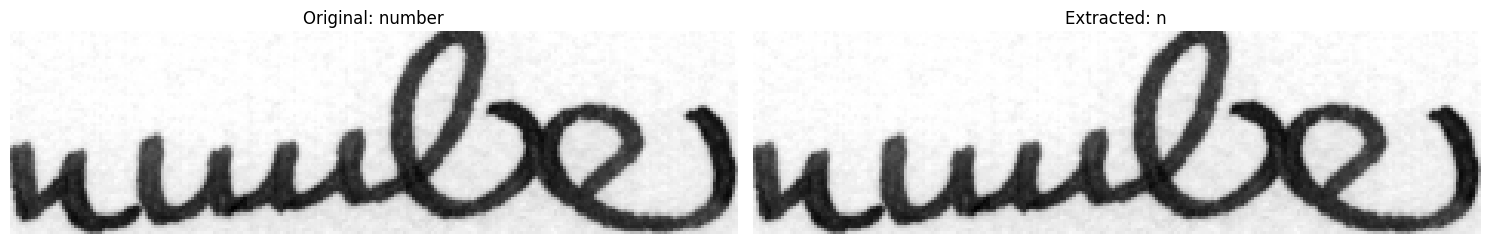

Image Path: Datasets\iam_words\words\a01\a01-007\a01-007-04-04.png
Label: an


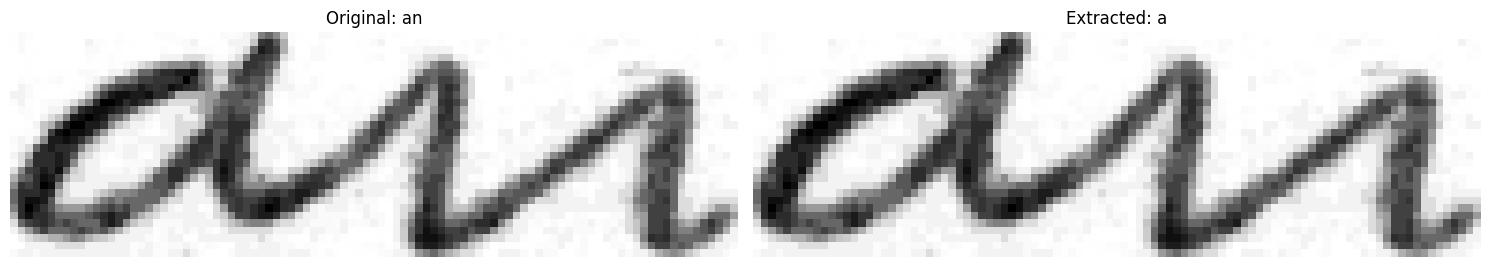

Image Path: Datasets\iam_words\words\a01\a01-053x\a01-053x-08-05.png
Label: considered


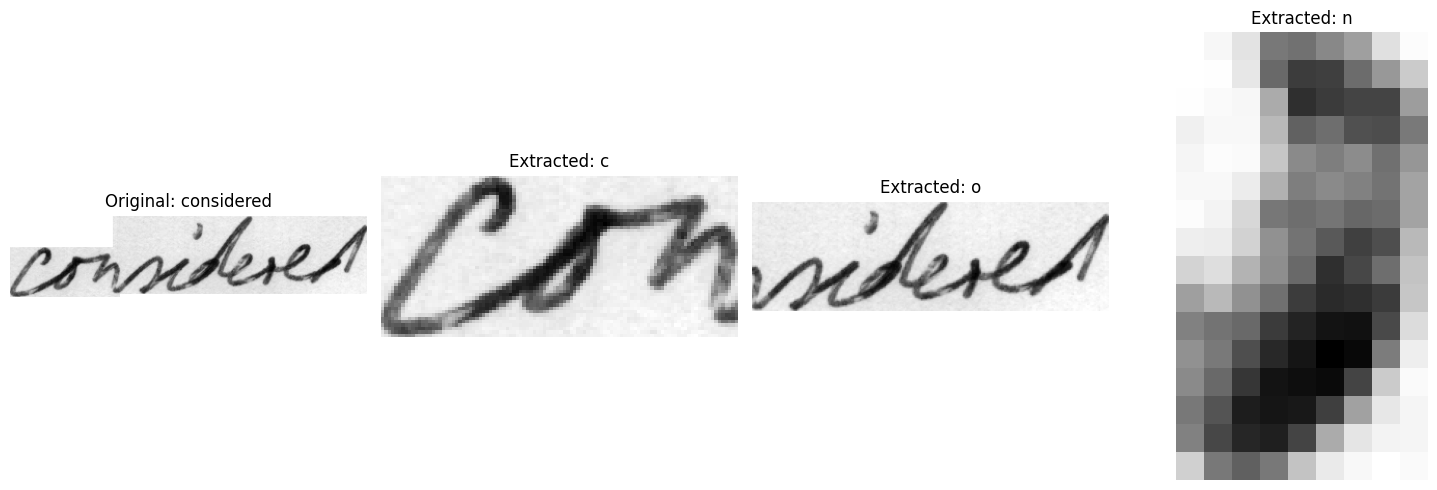

Image Path: Datasets\iam_words\words\a01\a01-020x\a01-020x-04-00.png
Label: plans


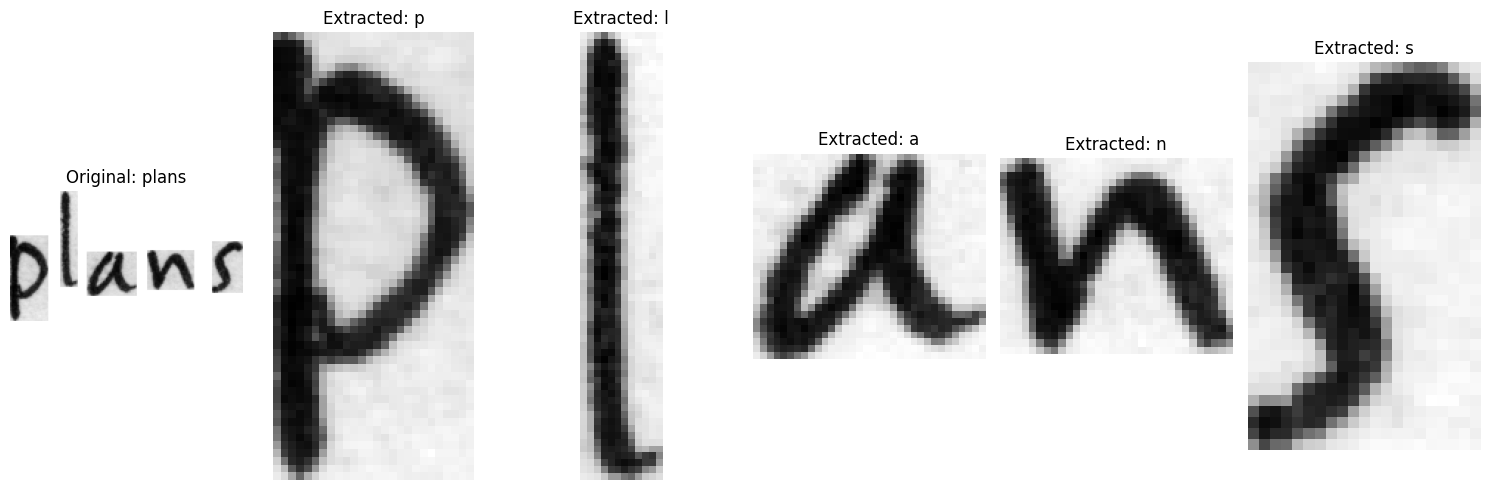

In [48]:
import matplotlib.pyplot as plt
import random
import cv2
from PIL import Image
import numpy as np


def extract_letters_from_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    letter_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > img.shape[0] * 0.2:
            letter = img[y:y + h, x:x + w]
            letter_images.append((x, letter))

    letter_images = sorted(letter_images, key=lambda x: x[0])
    letter_images = [img for _, img in letter_images]
    return letter_images

def display_comparison(image_path, label, extracted_images):
    original_img = Image.open(image_path)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(extracted_images) + 1, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f"Original: {label}")
    plt.axis('off')

    for i, (img, char) in enumerate(zip(extracted_images, label), start=2):
        plt.subplot(1, len(extracted_images) + 1, i)
        plt.imshow(img, cmap='gray')
        plt.title(f"Extracted: {char}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_examples = random.sample(dataset, 5)

for example in sample_examples:
    image_path, label = example
    print(f"Image Path: {image_path}")
    print(f"Label: {label}")

    extracted_images = extract_letters_from_image(image_path)
    
    if len(extracted_images) == len(label):
        display_comparison(image_path, label, extracted_images)
    else:
        print(f"Warning: Number of extracted images ({len(extracted_images)}) does not match label length ({len(label)}) for {image_path}")
        display_comparison(image_path, label, extracted_images)


### Inne śmieci

In [ ]:
# # Prepare data for training the neural network
# X = [cv2.resize(img, (28, 28)) for img, _ in letters_dataset]  # Resize images to 28x28
# X = np.array(X).reshape(-1, 28, 28, 1) / 255.0  # Normalize and reshape

# y = [char for _, char in letters_dataset]
# y = np.array([ord(c) - ord('A') for c in y])  # Encode characters as indices

In [ ]:
# # Create a ModelConfigs object to store model configurations
# configs = ModelConfigs()

# # Save vocab and maximum text length to configs
# configs.vocab = "".join(vocab)
# configs.max_text_length = max_len
# configs.save()

# # Create a data provider for the dataset
# data_provider = DataProvider(
#     dataset=dataset,
#     skip_validation=True,
#     batch_size=configs.batch_size,
#     data_preprocessors=[ImageReader(CVImage)],
#     transformers=[
#         ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
#         LabelIndexer(configs.vocab),
#         LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
#         imagesgowCV2()
#     ],
# )

# for _ in data_provider:
#     pass

In [ ]:
# # Przykład używania funkcji do przetwarzania danych obrazowych
# word_images = extract_word_images(data)

# # Przygotowanie danych do trenowania
# X = np.array(word_images)
# X = X.reshape(-1, 28, 28, 1)  # Dopasowanie kształtu do wejścia CNN
# y = data['transcription']

# # Zakodowanie etykiet (np. konwersja liter na indeksy lub one-hot encoding)
# # Przykładowe kodowanie przy użyciu one-hot encoding dla przykładu
# y_encoded = to_categorical(y)

# # Podział na zbiór treningowy i walidacyjny
# X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# # Budowanie modelu CNN (przykładowa architektura)
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(len(y.unique()), activation='softmax'))  # Liczba klas - unikalne transkrypcje

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Trenowanie modelu
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# # Ewaluacja modelu
# test_loss, test_acc = model.evaluate(X_val, y_val)
# print(f'Test accuracy: {test_acc}')


In [71]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


def encode_labels(labels, vocab, max_len):
    vocab_dict = {char: idx for idx, char in enumerate(sorted(vocab))}
    encoded_labels = []
    for label in labels:
        encoded_label = [vocab_dict[char] for char in label]  # Convert characters to indices
        encoded_labels.append(encoded_label)
    padded_labels = pad_sequences(encoded_labels, maxlen=max_len, padding='post')
    return np.array([to_categorical(seq, num_classes=len(vocab)) for seq in padded_labels])



sentences_txt_path = os.path.join("Datasets", "words_new.txt")
sentences_folder_path = os.path.join("Datasets", "iam_words", "words")

dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()

for line in tqdm(words[:10000]):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == 'err':
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    rel_path = os.path.join(sentences_folder_path, folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))




# # Stałe
# BATCH_SIZE = 32
# # IMG_HEIGHT, IMG_WIDTH = 64, 128  # Rozmiar obrazu

# images, labels = load_word_images(dataset)

# augmented_images = images
# augmented_labels = labels

# # Kodowanie etykiet
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(augmented_labels)  # użycie zaugmentowanych etykiet
# y_categorical = to_categorical(y_encoded)

# # # Podział danych na treningowe i walidacyjne
# # X_train, X_val, y_train, y_val = train_test_split(augmented_images, y_categorical, test_size=0.2, random_state=42)






# # # Wyodrębnianie ścieżek i etykiet do list
# # X = [item[0] for item in dataset]
# # y = [item[1] for item in dataset]  # Etykiety (pełne słowa lub litery)

# X = augmented_images
# y = y_categorical

# Funkcja do przygotowania danych obrazowych
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, color_mode='grayscale', target_size=(128, 32))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

# Funkcja do dekodowania etykiety (one-hot) na tekst
def decode_labels(encoded_labels, label_encoder, max_len):
    decoded_labels = []
    for encoded in encoded_labels:
        decoded_label = ''.join([label_encoder.inverse_transform([np.argmax(char)])[0] for char in encoded])
        decoded_labels.append(decoded_label)
    return decoded_labels

# Użycie stratified k-fold cross-validation
n_splits = 5  # Liczba podziałów
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Przechowywanie wyników dla każdego folda
fold_losses = []
fold_accuracies = []
fold_predictions = []

# Predykcje są one-hot encoded, więc musimy je zamienić na indeksy
fold_predictions_decoded = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}")
    X_train_paths, X_val_paths = [X[i] for i in train_index], [X[i] for i in val_index]
    y_train, y_val = [y[i] for i in train_index], [y[i] for i in val_index]

    # Załadowanie obrazów
    X_train = load_images(X_train_paths)
    X_val = load_images(X_val_paths)


    # Convert each word to a sequence of character indices
    label_encoder = LabelEncoder()
    label_encoder.fit(list(vocab))  # Fit on the vocabulary

     # Encode training and validation labels
    y_train = encode_labels(y_train, vocab, max_len)
    y_val = encode_labels(y_val, vocab, max_len)

    
    # Przygotowanie etykiet (one-hot encoding)
    y_train = np.array([list(label) for label in y_train])
    y_val = np.array([list(label) for label in y_val])

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 32, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(max_len * len(vocab), activation='softmax'),  # Adjust for sequence output
        tf.keras.layers.Reshape((max_len, len(vocab)))  # Reshape for sequence compatibility
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Trenowanie modelu
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
    
    # Walidacja modelu
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Fold {fold+1} - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    # Przechowywanie wyników
    fold_losses.append(val_loss)
    fold_accuracies.append(val_accuracy)
    
     # Predykcja na danych walidacyjnych
    predictions = model.predict(X_val)
    
    # # Przechowywanie predykcji folda
    # fold_predictions.append(predictions)

    # Dekodowanie predykcji
    decoded_predictions = decode_labels(predictions, label_encoder, max_len)
    decoded_y_val = decode_labels(y_val, label_encoder, max_len)

    # Przechowywanie predykcji
    fold_predictions_decoded.append((decoded_predictions, decoded_y_val, X_val_paths))

# Fuzja wyników predykcji i porównanie
all_decoded_predictions = []
all_decoded_y_val = []
all_X_val_paths = []

for fold_predictions, fold_labels, fold_paths in fold_predictions_decoded:
    all_decoded_predictions.extend(fold_predictions)
    all_decoded_y_val.extend(fold_labels)
    all_X_val_paths.extend(fold_paths)

# Wyświetlanie obrazków z rzeczywistymi etykietami i predykcjami
def plot_predictions(X_paths, y_true, y_pred, num_images=15):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = load_img(X_paths[i], color_mode='grayscale', target_size=(128, 32))
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"True: {y_true[i]}\nPred: {y_pred[i]}")
    plt.show()

# Wybór losowych obrazków do wyświetlenia
plot_predictions(all_X_val_paths[:5], all_decoded_y_val[:5], all_decoded_predictions[:5])

# Obliczanie średnich metryk
mean_loss = np.mean(fold_losses)
mean_accuracy = np.mean(fold_accuracies)
# all_predictions = np.mean(fold_predictions, axis=0)

print(f"Average Loss across all folds: {mean_loss:.4f}")
print(f"Average Accuracy across all folds: {mean_accuracy:.4f}")

# Podsumowanie maksymalnej długości słowa
print(f"Max length of labels: {max_len}")
# Wyświetlenie unikalnych znaków w słowniku
print(f"Vocabulary: {sorted(vocab)}")

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

IndexError: list index out of range

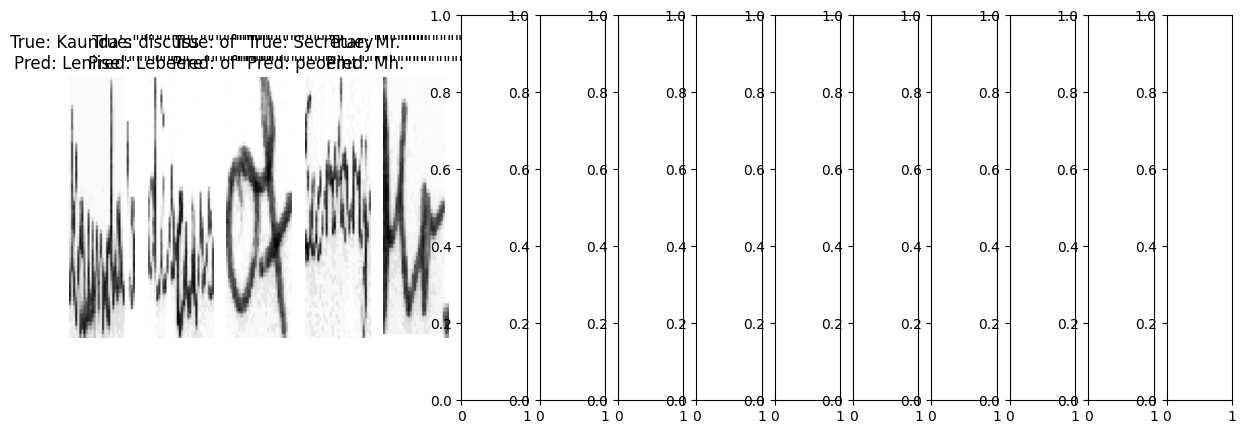

In [69]:
# Wybór losowych obrazków do wyświetlenia
for i in range(100, 5, -5):
    plot_predictions(all_X_val_paths[i:i+5], all_decoded_y_val[i:i+5], all_decoded_predictions[i:i+5])


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.